# **Letter classification algorithm**

# Read database

Functions used to read the database (train and test) from MNIST and also from the csv file generated with the images captured from the pico camera

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV
from sklearn.externals import joblib
import string

# Generate datasets

In [2]:
import dataTools as dt

In [3]:
%%time

X_train, Y_train = dt.create_train_data(1)

Generating TRAIN data...
Creating dataset...
Number of the lines in the dataset: 99840
Number of the lines in the dataset: 99840

Finished creating dataset

CPU times: user 18min 25s, sys: 3.17 s, total: 18min 28s
Wall time: 18min 28s


In [4]:
%%time

X_test, Y_test = dt.create_test_data(1)

Generating TEST data...
Creating dataset...
Number of the lines in the dataset: 20800
Number of the lines in the dataset: 20800

Finished creating dataset

CPU times: user 3min 46s, sys: 424 ms, total: 3min 46s
Wall time: 3min 46s


In [5]:
%%time

X_validation, Y_validation = dt.create_validation_data(1)

Generating VALIDATION data...
Creating dataset...
Number of the lines in the dataset: 24960
Number of the lines in the dataset: 24960

Finished creating dataset

CPU times: user 4min 34s, sys: 408 ms, total: 4min 35s
Wall time: 4min 34s


# **KK Neighborhod algorithm**

In [6]:
def plot_confusion_matrix(clf, data_x, data_y):
    classes = string.ascii_uppercase
    
    Ypred = clf.predict(data_x)
    
    # Computation of confusion matrix on testing set
    cm = confusion_matrix(data_y, Ypred)
    
    plt.figure(figsize=(15,12))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [7]:
def train_knnModel(i):  
    #Train the classifier
    print("Training KNN classifier...")
    clf = KNeighborsClassifier(n_neighbors=i)
    print("Finished trainning KNN classifier with " + str(i) + " neighbors")
    
    # Training KNN
    return clf.fit(X_train, Y_train)

knn_classificator = train_knnModel(5)

Training KNN classifier...
Finished trainning KNN classifier with 5 neighbors


The accuracy for test database is: 38.66%
Using: 99840 images


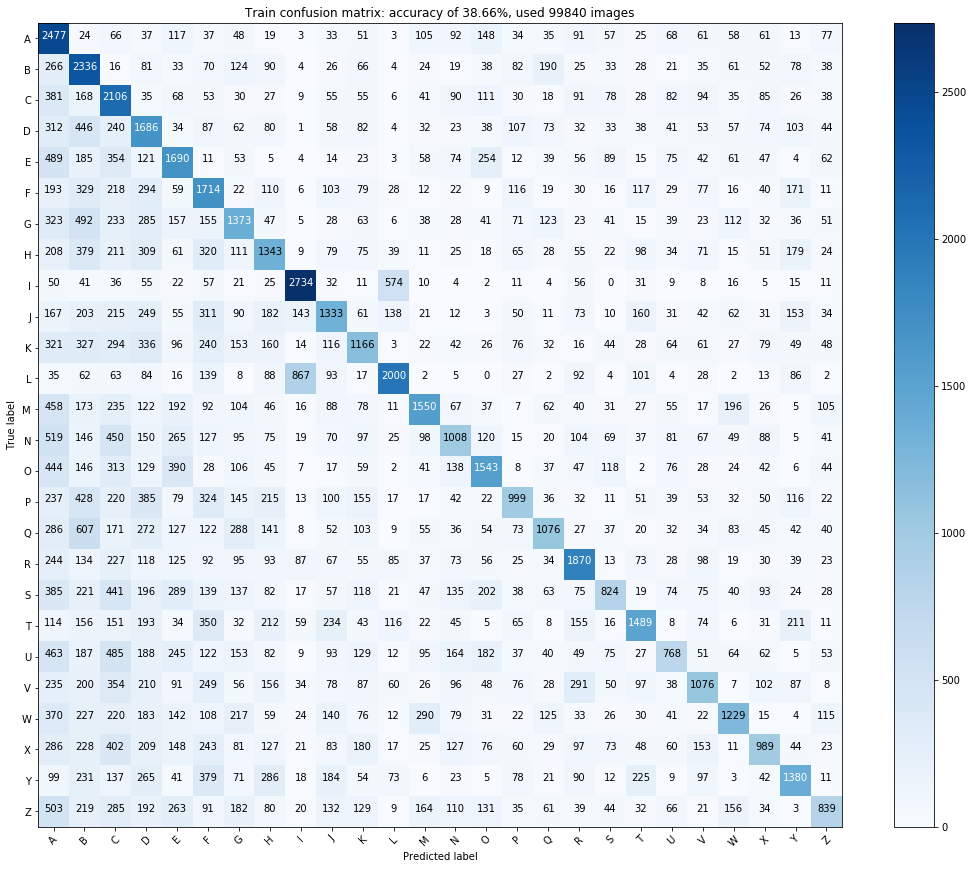

In [8]:
# Compute prediction accuracy on training set
def visualize_knnModel():
    predicted = knn_classificator.predict(X_train)
    print("The accuracy for test database is: " + str(round((accuracy_score(Y_train, predicted) * 100), 3)) + "%")

    print("Using: " + str(len(X_train)) + " images")
    
    plot_confusion_matrix(knn_classificator, X_train, Y_train)
    plt.title('Train confusion matrix: accuracy of ' + str(round((accuracy_score(Y_train, predicted) * 100), 3)) + "%, used " + str(len(X_train)) + " images")
    plt.savefig('./Results/knn/train')

visualize_knnModel()

The accuracy for test database is: 14.756%
Using: 24960 images


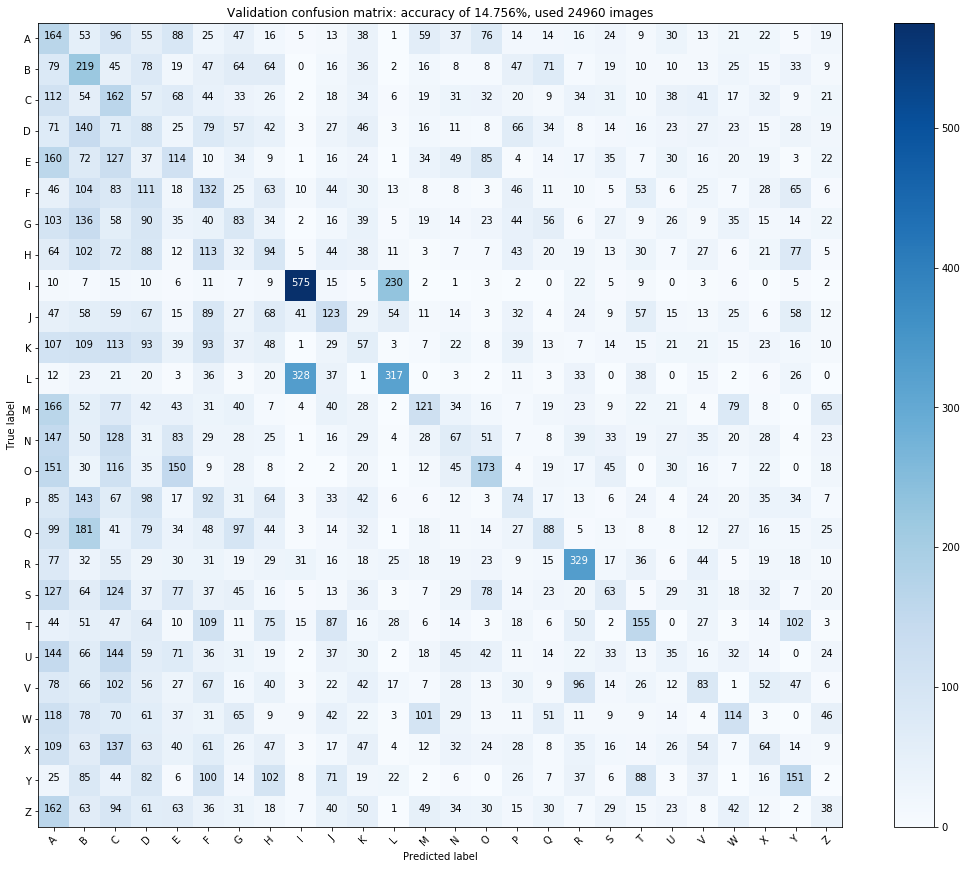

In [9]:
# Compute prediction accuracy on testing set
def validation_knnModel():
    predicted = knn_classificator.predict(X_validation)
    print("The accuracy for test database is: " + str(round((accuracy_score(Y_validation, predicted) * 100), 3)) + "%")

    print("Using: " + str(len(X_validation)) + " images")
    
    plot_confusion_matrix(knn_classificator, X_validation, Y_validation)
    plt.title('Validation confusion matrix: accuracy of ' + str(round((accuracy_score(Y_validation, predicted) * 100), 3)) + "%, used " + str(len(X_validation)) + " images")
    plt.savefig('./Results/knn/validation')
    
validation_knnModel()

# **Evaluation methods**

This part contains the functions used to analyse the accuracy of the classifier

# **Multiple Hyperparameter Study**
This part consist in making a study of the hyperparameter of the classifier, using the gridsearch method from the scikitlearn library.

In [10]:
# Define the parameter values that should be searched
k_range = list(range(2, 20))

# Another parameter besides k that we might vary is the weights parameters or even the algorithm
weight_options = ['uniform', 'distance']
#algorithm_options = ['auto', 'ball_tree', 'kd_tree', 'brute']

# Specify "parameter grid"
param_grid = dict(n_neighbors=k_range, weights=weight_options)

# Specify "parameter distributions" rather than a "parameter grid"
param_dist = dict(n_neighbors=k_range, weights=weight_options)

# Since both parameters are discrete, so param_dist is the same as param_grid

# Finally define the classifier, in this case the KNN classifier
knn = KNeighborsClassifier()

In [11]:
%%time

grid_best_scores = []
grid_best_params = []
grid_best_estimator = []

rand_best_scores = []
rand_best_params = []
rand_best_estimator = []

for i in list(range(15)):
    print i
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', n_jobs = -1)
    grid.fit(X_train, Y_train)
    grid_best_scores.append(grid.best_score_)
    grid_best_params.append(grid.best_params_)
    grid_best_estimator.append(grid.best_estimator_)

    rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10, n_jobs = -1)
    rand.fit(X_train, Y_train)
    rand_best_scores.append(rand.best_score_)
    rand_best_params.append(rand.best_params_)
    rand_best_estimator.append(rand.best_estimator_)
    
print("Finished searching the hyper parameters!")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Finished searching the hyper parameters!
CPU times: user 3min 48s, sys: 9.52 s, total: 3min 57s
Wall time: 48min 8s


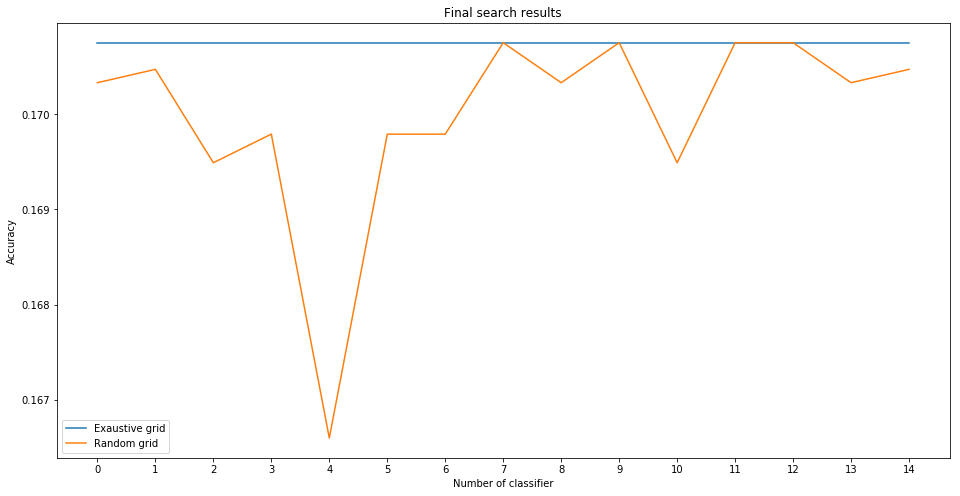

GRID SEARCH RESULTS
The best accuracy is: 17.075320512820515%
The parameters is: {'n_neighbors': 18, 'weights': 'distance'}


RANDOMGRID SEARCH RESULTS
The best accuracy is: 17.075320512820515%
The parameters is: {'n_neighbors': 18, 'weights': 'distance'}


In [12]:
# This block draw accuracies of the differents classifiers used in the grid and random search

plt.figure(figsize=(16, 8))
plt.title("Final search results")   
plt.plot(range(len(grid_best_scores)), grid_best_scores, label = 'Exaustive grid')
plt.plot(range(len(rand_best_scores)), rand_best_scores, label = 'Random grid')
plt.xlabel('Number of classifier')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(range(len(grid_best_scores)))
plt.show()

print("GRID SEARCH RESULTS")
print("The best accuracy is: " + str(np.max(grid_best_scores) * 100) + "%")
print("The parameters is: " + str(grid_best_params[np.argmax(grid_best_scores)]))
print('\n')
print("RANDOMGRID SEARCH RESULTS")
print("The best accuracy is: " + str(np.max(rand_best_scores) * 100) + "%")
print("The parameters is: " + str(rand_best_params[np.argmax(rand_best_scores)]))

# Best KNN classificator

In [13]:
#Train the best classificator for a N sample of numbers
def train_best_classifier():   
    classificator = rand_best_estimator[np.argmax(rand_best_scores)]

    return classificator.fit(X_train, Y_train)

In [14]:
best_knn_classificator = train_best_classifier()

The accuracy for test database is: 17.317%
Using: 20800 images


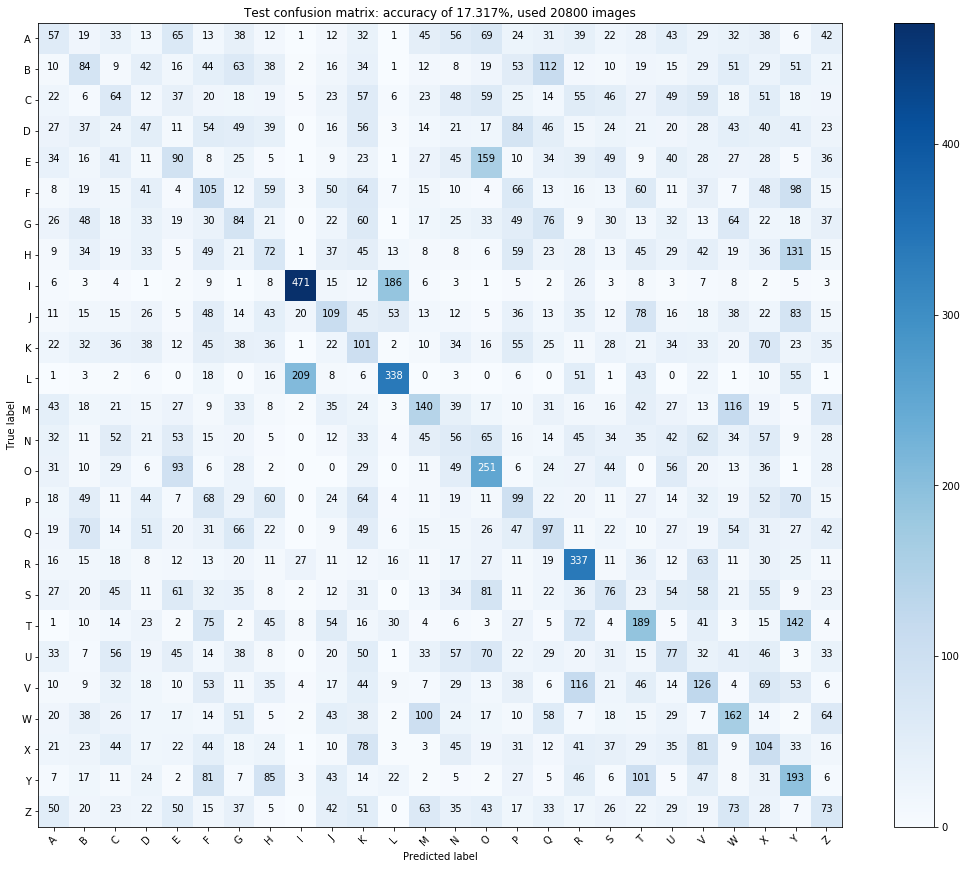

In [15]:
# Compute prediction accuracy on testing set
def test_knnModel():
    predicted = best_knn_classificator.predict(X_test)
    print("The accuracy for test database is: " + str(round((accuracy_score(Y_test, predicted) * 100), 3)) + "%")

    print("Using: " + str(len(X_test)) + " images")
    
    plot_confusion_matrix(best_knn_classificator, X_test, Y_test)
    plt.title('Test confusion matrix: accuracy of ' + str(round((accuracy_score(Y_test, predicted) * 100), 3)) + "%, used " + str(len(X_test)) + " images")
    plt.savefig('./Results/knn/test')

test_knnModel()

# Save model

In [16]:
# save the classifier
filename = './../application/knn/knn_classifier.sav'
joblib.dump(knn_classificator, filename, compress = 3)  

['./../application/knn/knn_classifier.sav']

In [17]:
# save the classifier
filename = './../application/knn/best_knn_classifier.sav'
joblib.dump(best_knn_classificator, filename, compress = 3)  

['./../application/knn/best_knn_classifier.sav']